In [ ]:
!git clone https://github.com/ToelUl/Thermal-Phase-Transition-MC-GPU-Simulation.git

!cp -r Thermal-Phase-Transition-MC-GPU-Simulation/gpu_mc ./

In [9]:
import time
import matplotlib.pyplot as plt

from gpu_mc import XYModel

import torch

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

✅ GPU runtime is enabled and ready!


In [10]:
L = 16 # Lattice size
T_start = 0.1
T_end = 2.0
precision = 0.05
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 15 # Number of chains
pt_interval = 1 # Parallel tempering interval
factor_therm = 20 # 10~50
factor_decorrelate = 2 # 1~10
tau = L**2 # Autocorrelation time
tau_eff = (10 * pt_interval * tau) / (10 * pt_interval + tau) # Effective Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * tau_eff) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_xy = XYModel(
    L=L,
    T=T,
    n_chains=n_chains,
    # adaptive=True,
    # target_acceptance=0.6,
    # adapt_rate=0.1,
    device=torch.device(device),
    use_amp=True,
    pt_enabled=True, # Suggestions: Parallel tempering enabled for better sampling.
    )

start = time.time()
samples_xy = sampler_xy(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate, pt_interval=pt_interval)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Number of sweeps: 3800
Number of thermalization sweeps: 5120
Number of chains: 15
Number of decorrelate: 19
Elapsed time: 28.71 s


Samples shape: torch.Size([38, 3000, 16, 16])


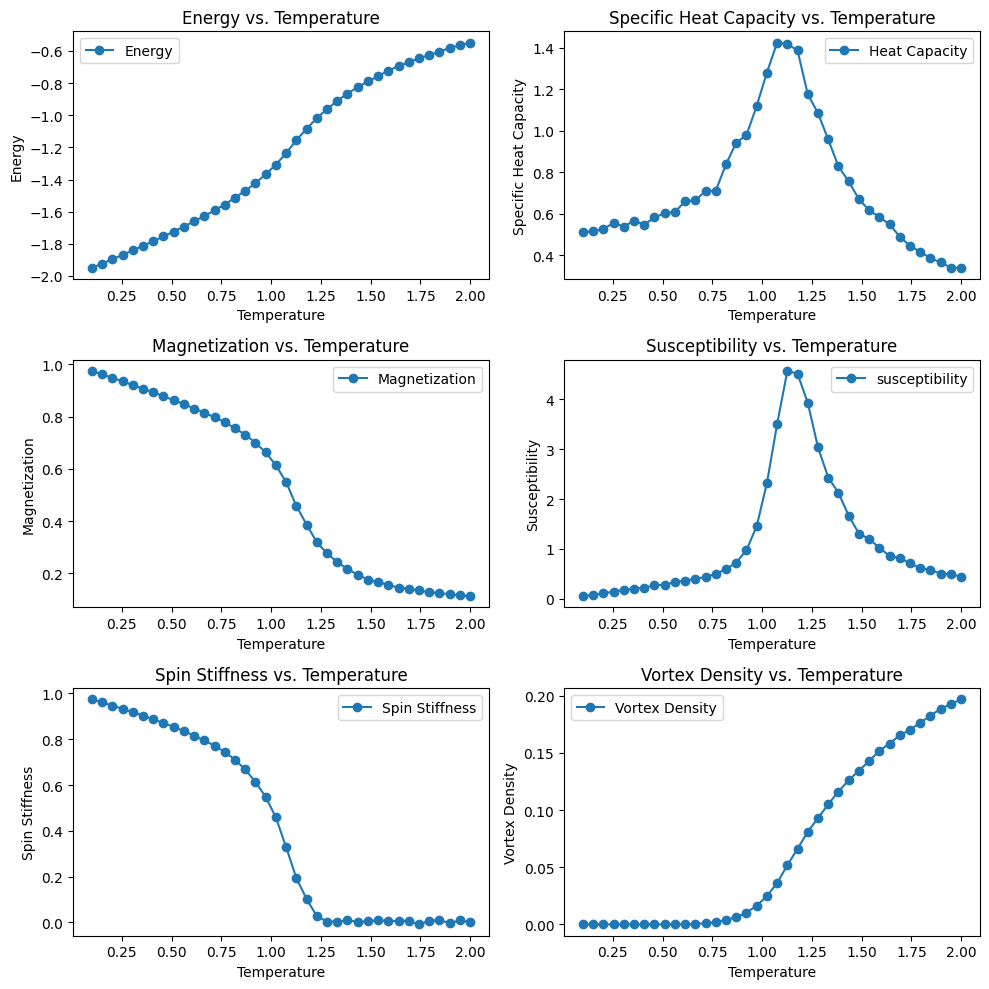

In [11]:
print(f"Samples shape: {samples_xy.shape}")

sampler_xy.spins = samples_xy

energy_xy = sampler_xy.compute_energy().mean(dim=1).cpu().numpy() / L**2
capacity_xy = sampler_xy.compute_heat_capacity().cpu().numpy()
stiffness_xy = sampler_xy.compute_spin_stiffness().cpu().numpy()
magnetization_xy = sampler_xy.compute_magnetization().cpu().numpy()
susceptibility_xy = sampler_xy.compute_susceptibility().cpu().numpy()
vortex_density_xy = sampler_xy.compute_vortex_density().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(321)
plt.plot(T.cpu().numpy(), energy_xy, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(322)
plt.plot(T.cpu().numpy(), capacity_xy, label='Heat Capacity', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat Capacity')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(323)
plt.plot(T.cpu().numpy(), magnetization_xy, label='Magnetization', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(324)
plt.plot(T.cpu().numpy(), susceptibility_xy, label='susceptibility', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(325)
plt.plot(T.cpu().numpy(), stiffness_xy, label='Spin Stiffness', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Spin Stiffness')
plt.title('Spin Stiffness vs. Temperature')
plt.legend()
plt.subplot(326)
plt.plot(T.cpu().numpy(), vortex_density_xy, label='Vortex Density', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Vortex Density')
plt.title('Vortex Density vs. Temperature')
plt.legend()
plt.tight_layout()
plt.show()